In [74]:
import json
import re
import os
from pathlib import Path

import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import tifffile
import torch
import torch.nn.functional as T
import torchvision.transforms.functional as TF
import wandb
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
from pytorch_lightning.loggers import WandbLogger

In [75]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
%autoreload 2

In [77]:
import mushroom.utils as utils

In [78]:
fps = sorted(utils.listfiles('../data/test_registration/HT397B1_v2/registered/', regex=r'/s[0-9]+\..*$'))
fps

['../data/test_registration/HT397B1_v2/registered/s0.h5ad',
 '../data/test_registration/HT397B1_v2/registered/s1.ome.tiff',
 '../data/test_registration/HT397B1_v2/registered/s2.ome.tiff',
 '../data/test_registration/HT397B1_v2/registered/s3.h5ad',
 '../data/test_registration/HT397B1_v2/registered/s4.ome.tiff',
 '../data/test_registration/HT397B1_v2/registered/s5.ome.tiff']

In [80]:
slice_to_adata = {}
for fp in fps:
    if '.h5ad' in fp:
        sid = re.sub(r'^(s[0-9]+).*$', r'\1', fp.split('/')[-1])
        print(sid)
        a = sc.read_h5ad(fp)
        sc.pp.normalize_total(a, target_sum=1e4)
        sc.pp.log1p(a)
        sc.pp.scale(a)
        slice_to_adata[sid] = a

In [81]:
genes = next(iter(slice_to_adata.values())).var.index.to_list()
slice_to_adata = {k:a[:, genes] for k, a in slice_to_adata.items()}

StopIteration: 

In [8]:
a = next(iter(slice_to_adata.values()))
a

View of AnnData object with n_obs × n_vars = 3058 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'he_rescaled', 'he_rescaled_warped', 'spatial', 'log1p'
    obsm: 'he_rescaled_spatial', 'spatial', 'spatial_original'

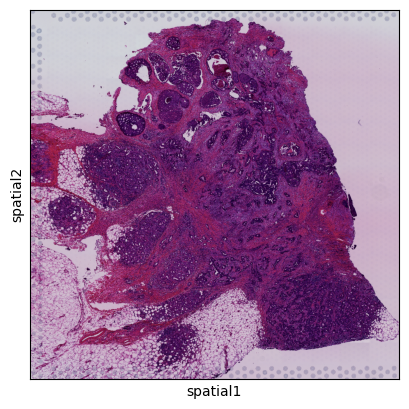

In [9]:
sc.pl.spatial(a)

In [10]:
target_shape = a.uns['he_rescaled_warped'].shape
target_shape

(15730, 15510, 3)

In [11]:
import torchvision

In [82]:
xyzc = np.load('../data/slice_clustering/slice_clusterer/slice_clusterer_v1/results/20kmeans_xyz.npy')

In [83]:
labeled_slices = utils.coords_to_labeled_slices(xyzc[:, :-1], xyzc[:, -1])

In [84]:
labeled_slices = [
    TF.resize(torch.tensor(x, dtype=torch.uint8).unsqueeze(0), (target_shape[0], target_shape[1]),
              antialias=False, interpolation=torchvision.transforms.InterpolationMode.NEAREST).squeeze().numpy()
    for x in labeled_slices]
len(labeled_slices), labeled_slices[0].shape

(4, (15730, 15510))

In [85]:
slice_to_labeled = {
    's0': labeled_slices[0],
    's1': labeled_slices[1],
    's2': labeled_slices[2],
    's3': labeled_slices[3]
}

In [86]:
xyzc = np.load('../data/slice_clustering/slice_clusterer/slice_clusterer_v1/results/50kmeans_xyz.npy')
labeled_slices = utils.coords_to_labeled_slices(xyzc[:, :-1], xyzc[:, -1])
labeled_slices = [
    TF.resize(torch.tensor(x, dtype=torch.uint8).unsqueeze(0), (target_shape[0], target_shape[1]),
              antialias=False, interpolation=torchvision.transforms.InterpolationMode.NEAREST).squeeze().numpy()
    for x in labeled_slices]
slice_to_labeled_specific = {
    's0': labeled_slices[0],
    's1': labeled_slices[1],
    's2': labeled_slices[2],
    's3': labeled_slices[3]
}

In [87]:
slice_to_labeled_specific_slide = {
    's0': torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1/metagene_dino_v2/results/s0_50knn.pt')['clustered_patches'].numpy(),
    's1': torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1_v1/codex/run_1/results/s1_50knn.pt')['clustered_patches'].numpy(),
    's2': torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1_v1/codex/run_1/results/s2_50knn.pt')['clustered_patches'].numpy(),
    's3': torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1/metagene_dino_v2/results/s3_50knn.pt')['clustered_patches'].numpy(),
}
slice_to_labeled_specific_slide = {
    k:TF.resize(torch.tensor(x, dtype=torch.uint8).unsqueeze(0), (target_shape[0], target_shape[1]),
              antialias=False, interpolation=torchvision.transforms.InterpolationMode.NEAREST).squeeze().numpy()
    for k, x in slice_to_labeled_specific_slide.items()}



In [18]:
meta = json.load(open('../data/test_registration/HT397B1_v2/registered/metadata.json'))
meta

{'downsample_scaler': 0.1,
 'phenocycler_pixels_per_micron': 1.9604911906033102,
 'order': ['HT397B1-S1H3A1U1',
  'HT397B1-S1H3A1U2',
  'HT397B1-S1H3A1U12',
  'HT397B1-S1H3A1U21',
  'HT397B1-S1H3A1U22',
  'HT397B1-S1H3A1U31'],
 'data_type': ['visium', 'codex', 'codex', 'visium', 'codex', 'codex'],
 'slices': ['s0', 's1', 's2', 's3', 's4', 's5']}

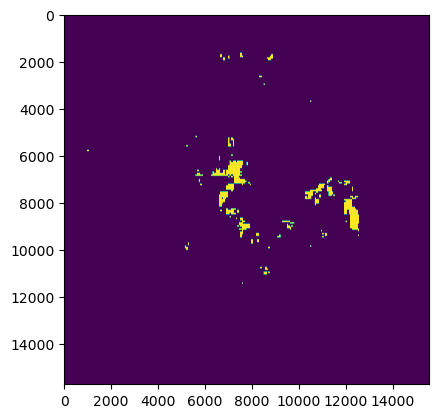

In [19]:
mask = labeled_slices[0]==11
plt.imshow(mask)

In [20]:
a.obsm['spatial'] # x,y

ArrayView([[ 5816, 11425],
           [ 4264,  3292],
           [11954, 10628],
           ...,
           [ 4439,  5546],
           [ 6653,  4071],
           [ 1880,  5453]])

In [21]:
def contains_spot(a, mask):
    bools = []
    for x, y in a.obsm['spatial']:
        if mask[y, x]:
            bools.append(True)
        else:
            bools.append(False)
    return bools

filtered = a[contains_spot(a, mask)]
filtered.shape

(85, 17943)

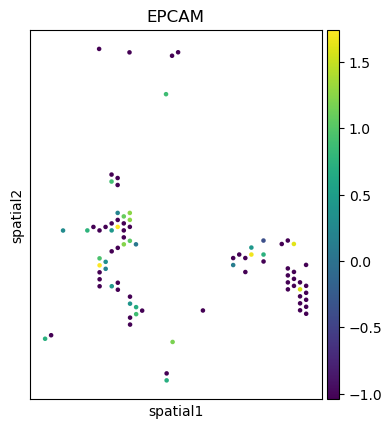

In [22]:
sc.pl.spatial(filtered, color=['EPCAM'], alpha_img=0.)

In [23]:
filtered.X.mean(0)

ArrayView([-0.1091752 , -0.45258126,  0.07993647, ...,  0.        ,
            0.        ,  0.        ], dtype=float32)

In [26]:
import pandas as pd
def get_cluster_exp_profiles(a, labeled):
    clusters = np.unique(labeled)
    data = []
    for c in clusters:
        mask = labeled==c
        filtered = a[contains_spot(a, mask)]
        exp = filtered.X.mean(0)
        data.append(np.expand_dims(exp, 0))
    data = np.concatenate(data)
    return pd.DataFrame(data=data, columns=a.var.index.to_list(), index=clusters)

In [27]:
df = get_cluster_exp_profiles(a, labeled_slices[0])
df

/tmp/ipykernel_3536371/2883666456.py:8: RuntimeWarning: Mean of empty slice.
  exp = filtered.X.mean(0)


,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,SRY,ZFY,PCDH11Y,AMELY,TBL1Y,TSPY1,USP9Y,DDX3Y,TMSB4Y,KDM5D
0,0.048726,0.098936,-0.164512,-0.082476,0.0,-0.117578,-0.133521,0.109528,-0.030942,-0.185675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.045199,-0.339493,0.182677,-0.282246,0.0,-0.243611,-0.143486,-0.110243,-0.030942,-0.060215,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.273226,-0.893116,-0.164512,-0.282246,0.0,-0.887956,-0.122674,-0.865324,-0.030942,-0.219095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.273226,-0.922976,-0.164512,-0.282246,0.0,-1.138399,-0.878218,-1.064367,-0.030942,-0.642444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.272782,-0.372154,0.431044,-0.228190,0.0,-0.528760,0.314640,-0.570132,-0.030942,-0.194701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-0.273226,-0.922976,-0.164512,-0.282246,0.0,1.625392,-0.878218,0.348821,-0.030942,-0.642444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.273226,0.196285,1.050294,-0.282246,0.0,-0.061236,-0.665793,0.747796,-0.030942,0.648818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-0.074242,0.511284,-0.060013,0.144267,0.0,0.450805,-0.213669,0.241022,-0.030942,0.421235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
slice_to_adata.keys()

dict_keys(['s0', 's3'])

In [29]:
def get_agg_exp_profiles(slice_to_adata, slice_to_labeled):
    agg = None
    for s in slice_to_adata.keys():
        print(s)
        a, labeled = slice_to_adata[s], slice_to_labeled[s]
        df = get_cluster_exp_profiles(a, labeled)
        if agg is None:
            agg = df
        else:
            agg += df
    agg /= len(slice_to_adata)
    return agg

In [30]:
df = get_agg_exp_profiles(slice_to_adata, slice_to_labeled)
df

s0


/tmp/ipykernel_3536371/2883666456.py:8: RuntimeWarning: Mean of empty slice.
  exp = filtered.X.mean(0)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


s3


/tmp/ipykernel_3536371/2883666456.py:8: RuntimeWarning: Mean of empty slice.
  exp = filtered.X.mean(0)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,C1orf159,...,SRY,ZFY,PCDH11Y,AMELY,TBL1Y,TSPY1,USP9Y,DDX3Y,TMSB4Y,KDM5D
0,-0.066252,-0.256625,-0.040576,-0.046821,-0.010336,-0.456576,-0.108842,-0.413553,-0.031135,-0.209970,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.061755,0.123930,0.000993,0.062165,-0.010336,0.318513,0.122015,0.297524,-0.031135,0.093772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.232802,-0.656310,-0.149317,0.229118,-0.010336,-0.062705,-0.371689,-0.255440,-0.031135,-0.320518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.032761,0.477476,0.027363,0.167803,0.085264,0.382298,0.212908,0.309241,0.024446,0.419886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-0.074450,-0.145349,0.069421,-0.007685,-0.010336,-0.125757,-0.141571,0.005895,-0.031135,-0.232744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.169935,-0.166530,-0.021571,-0.098834,-0.010336,-0.263555,-0.100102,-0.330012,-0.031135,-0.137560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
a

View of AnnData object with n_obs × n_vars = 3058 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'he_rescaled', 'he_rescaled_warped', 'spatial', 'log1p'
    obsm: 'he_rescaled_spatial', 'spatial', 'spatial_original'

In [32]:
for s, a in slice_to_adata.items():
    a.obs['integrated_cluster'] = [str(slice_to_labeled[s][y, x]) for x, y in a.obsm['spatial']]
    a.obs['specific_cluster'] = [str(slice_to_labeled_specific[s][y, x]) for x, y in a.obsm['spatial']]
    a.obs['specific_cluster_slide'] = [str(slice_to_labeled_specific_slide[s][y, x]) for x, y in a.obsm['spatial']]

/tmp/ipykernel_3536371/3590166962.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['integrated_cluster'] = [str(slice_to_labeled[s][y, x]) for x, y in a.obsm['spatial']]
/tmp/ipykernel_3536371/3590166962.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs['integrated_cluster'] = [str(slice_to_labeled[s][y, x]) for x, y in a.obsm['spatial']]


In [33]:
marker_genes_dict = {
    'Tumor': ['EPCAM', 'KRT18', 'MGP'],
    'Fibroblast': ['ACTA2', 'SPARC'],
    'Endothelial': ['PECAM1'],
    'CD4': ['IL7R'],
    'CD8': ['CD8A'],
    'Treg': ['FOXP3'],
    'B cell': ['MS4A1'],
    'Macrophage': ['CD68'],
    'Exhaustion': ['LAG3', 'PDCD1']
}

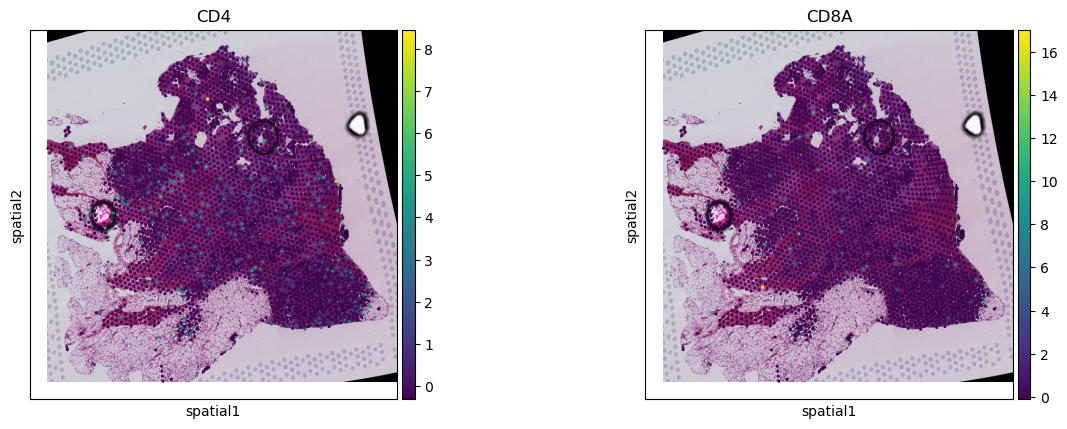

In [34]:
sc.pl.spatial(a, color=['CD4', 'CD8A'])

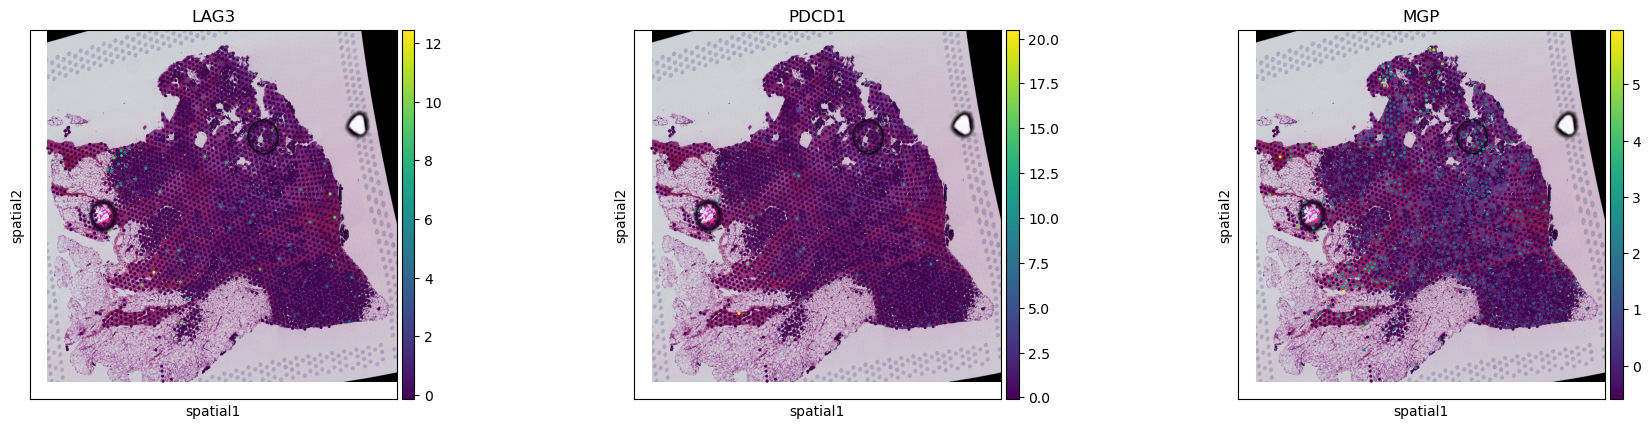

In [35]:
sc.pl.spatial(a, color=['LAG3', 'PDCD1', 'MGP'], use_raw=False)

In [36]:
import anndata
combined = anndata.concat(slice_to_adata.values())
combined.shape

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(5398, 17943)

In [37]:
filtered_combined = combined[[True if int(x) in [4, 10, 11, 18] else False
                              for x in combined.obs['integrated_cluster']]]
filtered_combined.shape

(2292, 17943)

In [38]:
sc.tl.rank_genes_groups(filtered_combined, groupby='integrated_cluster', )

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: Imp

         Falling back to preprocessing with `sc.pp.pca` and default params.


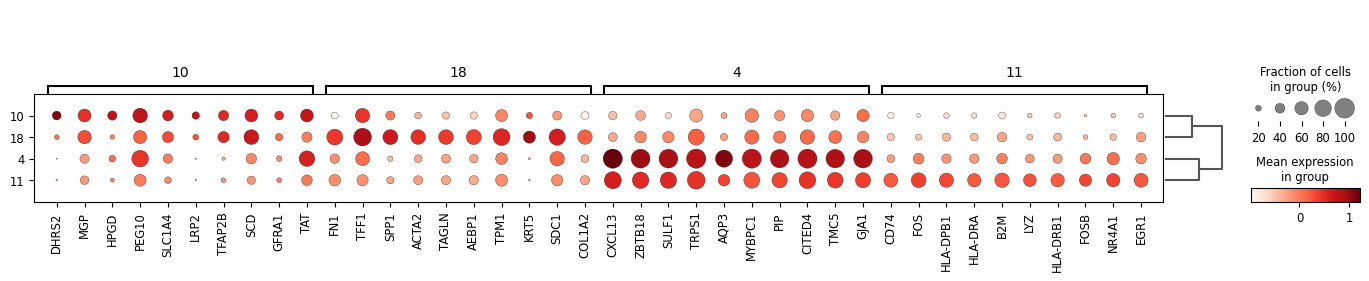

In [39]:
sc.pl.rank_genes_groups_dotplot(filtered_combined, n_genes=10)

In [40]:
import enrichrpy.enrichr as een
import enrichrpy.plotting as epl

genes = filtered_combined.uns['rank_genes_groups']['names']['11'][:20]
df = een.get_pathway_enrichment(genes, gene_set_library='GO_Biological_Process_2021')
df.iloc[:10]

,Rank,Term name,P-value,Z-score,Combined score,Overlapping genes,Adjusted p-value,Old p-value,Old adjusted p-value
0,1,interferon-gamma-mediated signaling pathway (G...,4.600367e-11,137.682028,3277.148918,"[HLA-DPB1, HLA-DRA, B2M, HLA-DRB1, HLA-E, HLA-...",2.074766e-08,0,0
1,2,cytokine-mediated signaling pathway (GO:0019221),1.081868e-10,31.700491,727.436306,"[IL32, EGR1, TMSB4X, HLA-DPB1, HLA-DRA, FOS, B...",2.439611e-08,0,0
2,3,antigen processing and presentation of exogeno...,5.884729e-10,87.848306,1867.083121,"[CD74, HLA-DPB1, HLA-DRA, HLA-DRB1, HLA-E, HLA...",8.150664e-08,0,0
3,4,antigen processing and presentation of endogen...,7.228970e-10,499.250000,10508.091350,"[HLA-DRA, B2M, HLA-DRB1, HLA-E]",8.150664e-08,0,0
4,5,cellular response to interferon-gamma (GO:0071...,1.564752e-09,74.031056,1501.019516,"[HLA-DPB1, HLA-DRA, B2M, HLA-DRB1, HLA-E, HLA-...",1.411406e-07,0,0
5,6,antigen processing and presentation of exogeno...,3.726352e-08,71.279570,1219.254944,"[CD74, HLA-DPB1, HLA-DRA, HLA-DRB1, HLA-DPA1]",2.364792e-06,0,0
6,7,antigen processing and presentation of peptide...,4.125949e-08,69.771930,1186.358967,"[CD74, HLA-DPB1, HLA-DRA, HLA-DRB1, HLA-DPA1]",2.364792e-06,0,0
7,8,positive regulation of T cell mediated immunit...,4.194754e-08,155.843750,2647.293807,"[HLA-DRA, B2M, HLA-DRB1, HLA-E]",2.364792e-06,0,0
8,9,positive regulation of cytokine production (GO...,6.714011e-07,25.598350,363.852363,"[EGR1, CD74, LAPTM5, HLA-DPB1, HLA-E, HLA-DPA1]",3.364466e-05,0,0
9,10,positive regulation of lymphocyte proliferatio...,8.442220e-07,70.102113,980.367557,"[CD74, HLA-DPB1, HLA-E, HLA-DPA1]",3.807441e-05,0,0


In [41]:
charts = []
charts.append(epl.enrichment_dotplot(df, n=10, hue='Z-score', log=True))

In [42]:
genes = filtered_combined.uns['rank_genes_groups']['names']['4'][:20]
df = een.get_pathway_enrichment(genes, gene_set_library='GO_Biological_Process_2021')
charts.append(epl.enrichment_dotplot(df, n=10, hue='Z-score', log=True))

genes = filtered_combined.uns['rank_genes_groups']['names']['10'][:20]
df = een.get_pathway_enrichment(genes, gene_set_library='GO_Biological_Process_2021')
charts.append(epl.enrichment_dotplot(df, n=10, hue='Z-score', log=True))

genes = filtered_combined.uns['rank_genes_groups']['names']['18'][:20]
df = een.get_pathway_enrichment(genes, gene_set_library='GO_Biological_Process_2021')
charts.append(epl.enrichment_dotplot(df, n=10, hue='Z-score', log=True))

In [43]:
charts[0]

alt.LayerChart(...)

In [44]:
charts[1]

alt.LayerChart(...)

In [45]:
charts[2]

alt.LayerChart(...)

In [46]:
charts[3]

alt.LayerChart(...)

In [79]:
fps = sorted(
    utils.listfiles('/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/', regex=r'ome.tiff$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s1.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s2.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s4.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s5.ome.tiff']

In [49]:
channel_to_img = utils.extract_ome_tiff(fps[1])

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


In [88]:
labeled = slice_to_labeled_specific_slide['s1']
labeled.shape

(15730, 15510)

In [53]:
next(iter(channel_to_img.values())).shape

(15730, 15510)

In [54]:
import pandas as pd
def get_cluster_exp_profiles_img(channel_to_img, labeled):
    clusters = np.unique(labeled)
    data = []
    for c in clusters:
        mask = labeled==c
        exp = []
        for channel, img in channel_to_img.items():
            exp.append(img[mask].mean())
        data.append(exp)
    data = np.asarray(data)
    return pd.DataFrame(data=data, columns=list(channel_to_img.keys()), index=clusters)

In [55]:
df = get_cluster_exp_profiles_img(channel_to_img, labeled)
df

,DAPI,CD8,Her2 (D),GATA3 (D),cKIT-(D),Pan-Cytokeratin,GLUT1-(D),Podoplanin,CD68 (D),HLA-DR,...,Ki67,Vimentin-(D),PR-(D),Bap1 (D),CD45 (D),ER,CD31,COX6c (D),CK19,PLAT/tPA (D)
0,2.036096,0.134601,0.040165,0.799269,0.185946,1.913360,0.977548,0.151545,0.032228,0.814159,...,0.113930,4.317843,1.174611,0.042193,0.291846,0.604335,0.227853,0.070194,0.603147,0.364567
1,4.445596,0.460932,0.061792,0.362893,0.651500,1.791401,1.591716,0.564797,0.092728,0.833083,...,0.148969,3.885759,0.892443,0.145096,0.519753,0.290107,0.197120,0.114825,0.733952,0.326419
2,4.649142,0.503097,0.075459,0.641490,0.775554,2.478561,2.062359,0.650067,0.096293,1.059387,...,0.239220,4.642589,1.403628,0.161072,0.618323,0.441760,0.251647,0.148835,1.088991,0.471299
3,23.123513,0.343022,0.847901,41.119344,1.610575,88.600355,19.588193,1.072067,0.600431,13.376948,...,3.270444,37.755686,14.910490,0.303107,4.691038,18.526835,2.397260,0.920014,28.406457,8.842808
4,3.802835,0.491575,0.070137,0.381619,0.742103,1.824401,1.898300,0.639456,0.080047,1.005934,...,0.228548,2.195412,0.738869,0.140210,0.565903,0.220471,0.153733,0.156053,0.618654,0.319617
5,10.553030,0.352752,0.153851,4.468446,0.487938,11.386040,3.942845,0.427835,0.126426,5.246941,...,0.520927,27.043109,9.707224,0.119445,1.469550,3.692048,1.433492,0.287783,4.093633,2.138851
6,4.141081,0.491326,0.062185,0.261796,0.726589,1.734631,1.614003,0.623010,0.094531,0.838729,...,0.147601,1.715878,0.274354,0.153216,0.509537,0.141262,0.132846,0.119092,0.583590,0.263174
7,9.356108,0.274546,0.118480,3.192114,0.490396,8.344267,3.756824,0.377065,0.105614,2.668733,...,0.504363,22.548848,11.950520,0.104576,1.046328,2.522799,1.208945,0.266316,2.844424,1.796788
8,7.285014,0.309550,0.095656,1.448251,0.472937,4.861235,3.068352,0.302532,0.084175,1.687046,...,0.432534,24.111271,7.111685,0.106367,0.731772,1.654824,1.119413,0.182519,1.945478,1.394640
9,14.677616,0.392324,0.280625,13.372255,0.591903,26.002642,6.148897,0.455328,0.204836,7.767817,...,1.283870,31.261455,11.845598,0.159420,2.482193,7.498039,2.142806,0.450650,9.493063,3.166646


In [64]:
scaled = df / df.max(axis=0)

In [56]:
import seaborn as sns

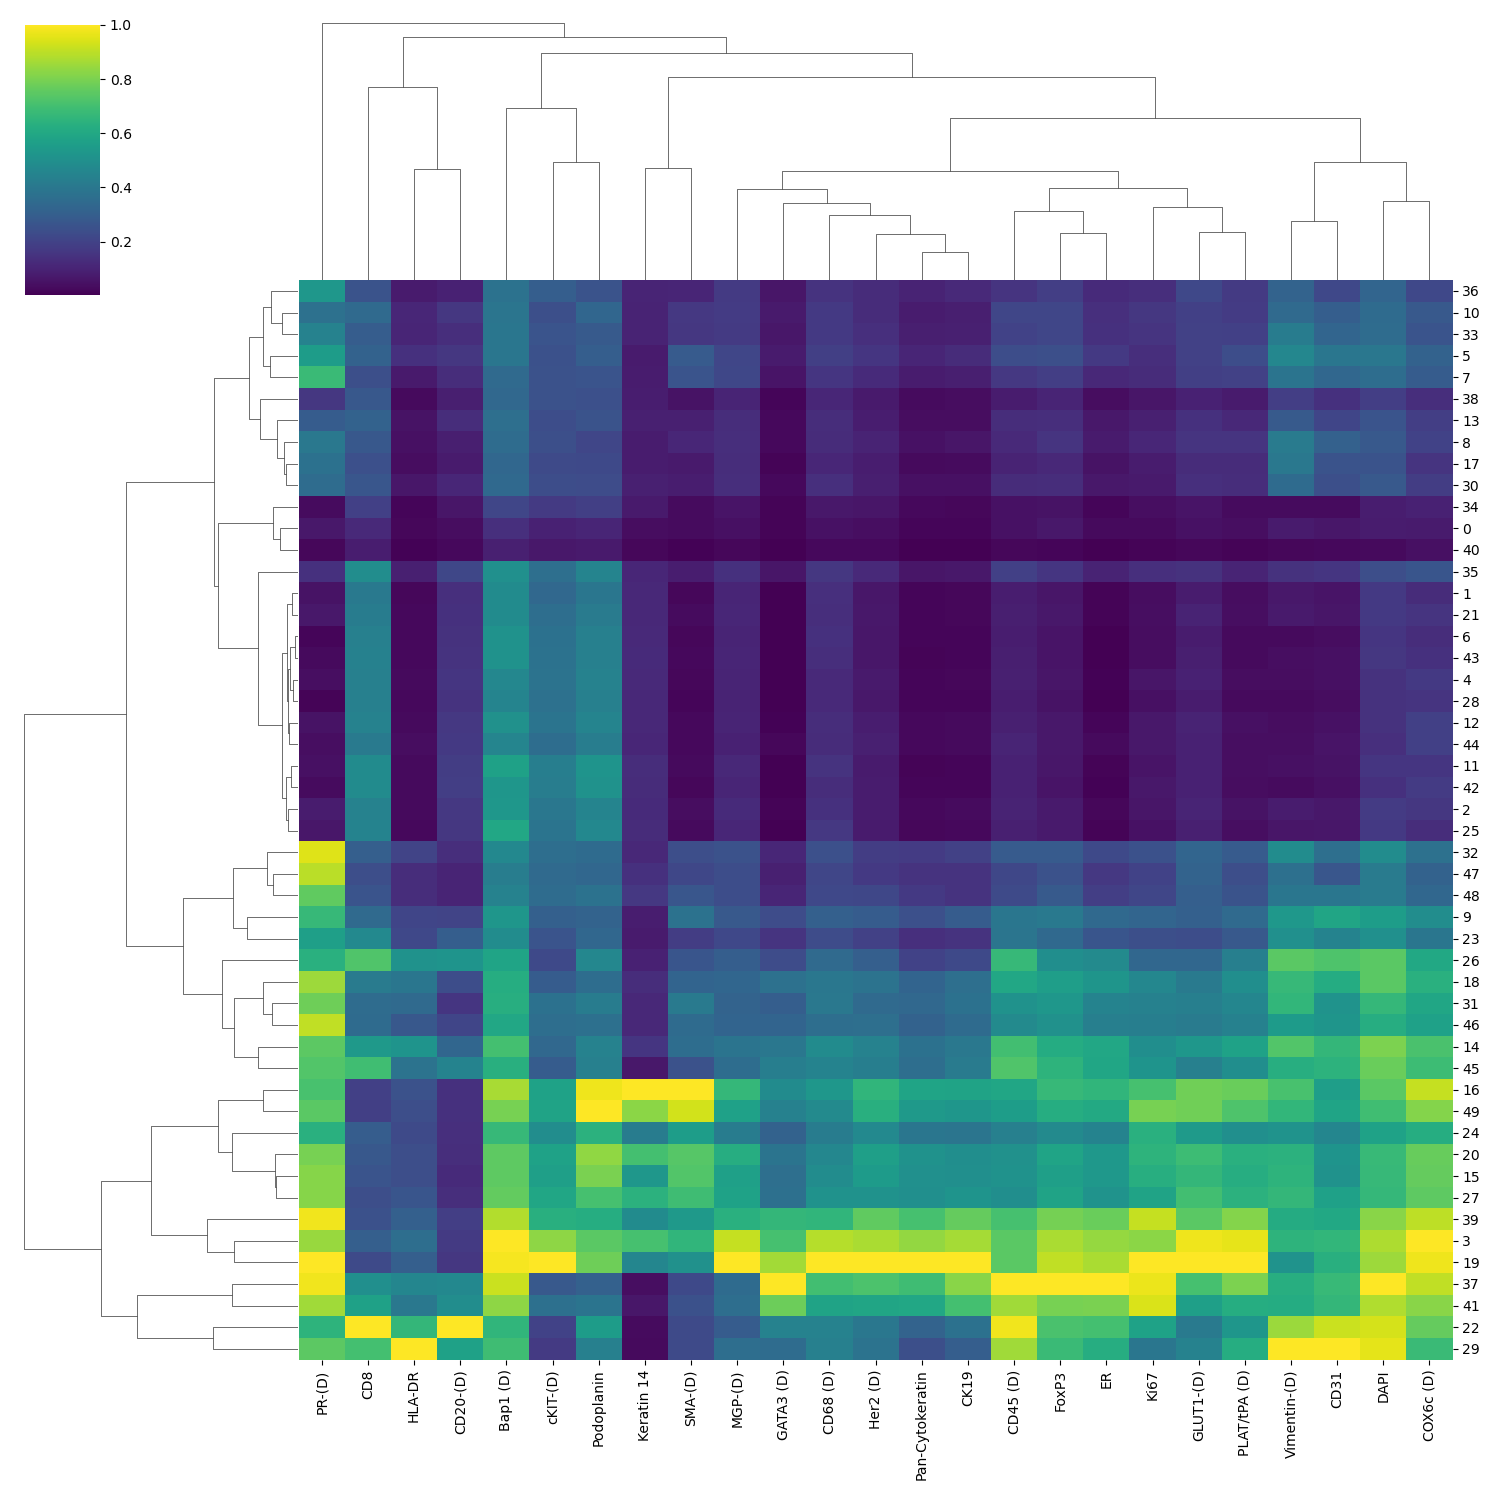

In [67]:
sns.clustermap(scaled, cmap='viridis', figsize=(15, 15))

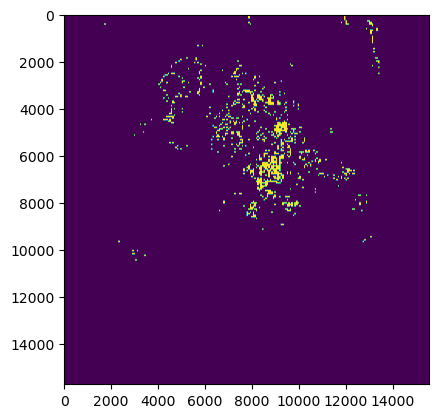

In [90]:
keep = [16, 49]
mask = np.asarray([labeled==c for c in keep]).sum(axis=0)
plt.imshow(mask)

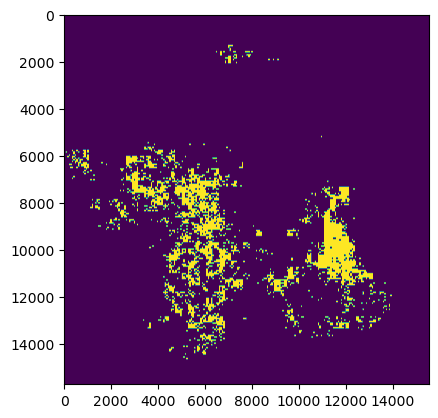

In [71]:
keep = [22, 29]
mask = np.asarray([labeled==c for c in keep]).sum(axis=0)
plt.imshow(mask)

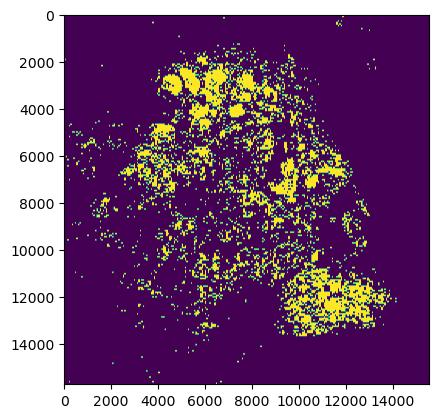

In [72]:
keep = [39, 3, 19, 37, 41]
mask = np.asarray([labeled==c for c in keep]).sum(axis=0)
plt.imshow(mask)

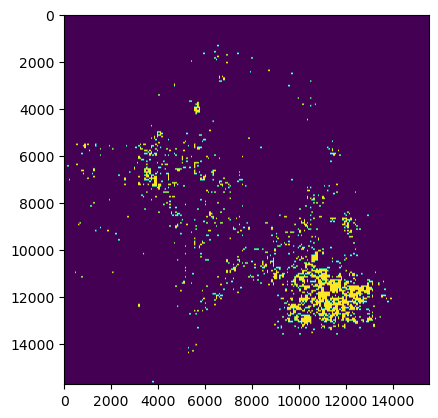

In [73]:
keep = [37]
mask = np.asarray([labeled==c for c in keep]).sum(axis=0)
plt.imshow(mask)